# Cythonが使えるかどうかテストしてみる

参照：https://qiita.com/kenmatsu4/items/7c08a85e41741e95b9ba

In [1]:
%load_ext Cython

In [3]:
%%cython
#-n 1019_P_Cython_using_test
def fib(int n):
    cdef int i
    cdef double a=0.0, b=1.0

    for i in range(n):
        a, b = a+b, a
    return a

def primes(int kmax):
    cdef int n, k, i
    cdef int p[1000]
    result = []

    if kmax > 1000:
        kmax = 1000

    k = 0
    n = 2
    while k < kmax:
        i = 0
        while i < k and n % p[i] != 0:
            i += 1

        if i == k:
            p[k] = n
            k += 1
            result.append(n)
        n += 1
    return result

In [4]:
print(fib(90))
print(primes(20))

2.880067194370816e+18
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]


cythonの方が何十倍も処理が早い！
データ同化でこれから処理が重くなることを考えると待った無しで使うべし

## ndarray使えるかな

In [9]:
# データを作る
import numpy.random as rd
import pandas as pd
rd.seed(71)
n_data = 10**5
X = pd.DataFrame(rd.normal(size=3*n_data).reshape((n_data,3)), columns=["a", "b", "c"])
print(X.shape)
print(X.head())

(100000, 3)
          a         b         c
0 -0.430603 -1.193928 -0.444299
1  0.489412 -0.451557  0.585696
2  1.177320 -0.965009  0.218278
3 -0.866144 -0.323006  1.412919
4 -0.712651 -1.362191 -1.705966


In [11]:
%%cython
# sample_calc
import numpy as np
cimport numpy as np

cpdef np.ndarray[double] sample_calc(np.ndarray col_a, np.ndarray col_b, np.ndarray col_c):
    # 各列の型チェック
    assert (col_a.dtype == np.float and col_b.dtype == np.float and col_c.dtype == np.float)

    # 各列のサイズが同じであることをチェック
    cdef Py_ssize_t n = len(col_c)
    assert (len(col_a) == len(col_b) == n)
    cdef np.ndarray[double] res = np.empty(n)

    # (a-b)/c という計算をする
    for i in range(n):
        res[i] = (col_a[i] - col_b[i])/col_c[i]
    return res

In [12]:
sample_calc(X.a.values, X.b.values, X.c.values)

array([-1.71804336,  1.60658332,  9.81468496, ..., -0.44683095,
        0.46970409, -0.28352272])

In [13]:
# 比較用
def pysample_calc(col_a, col_b, col_c):
    # 各列の型チェック
    assert (col_a.dtype == np.float and col_b.dtype == np.float and col_c.dtype == np.float)

    # 各列のサイズが同じであることをチェック
    n = len(col_c)
    assert (len(col_a) == len(col_b) == n)
    res = np.empty(n)

    # (a-b)/c という計算をする
    for i in range(n):
        res[i] = (col_a[i] - col_b[i])/col_c[i]
    return res

In [14]:
%timeit sample_calc(X.a.values, X.b.values, X.c.values)
%timeit pysample_calc(X.a.values, X.b.values, X.c.values)

10 loops, best of 3: 30.3 ms per loop
10 loops, best of 3: 63.4 ms per loop


cythonの方が倍速

## モンテカルロ法で円周率計算

In [15]:
# データ生成
rd.seed(71)
n_data = 10**7
X2 = rd.random(size=(n_data,2)).astype(np.float)
X2.dtype

dtype('float64')

In [16]:
%%cython
#-n calc_pi
import numpy as np
cimport numpy as np

cpdef np.ndarray[long]  calc_pi(np.ndarray[double, ndim=2] data):
    cdef Py_ssize_t n = len(data)
    cdef np.ndarray[long] res = np.empty(n, dtype=np.int)

    for i in range(n):
        res[i] = 1 if (data[i,0]**2 + data[i,1]**2) < 1 else 0
    return res

In [17]:
# 比較用Python関数
def pycalc_pi(data):
    n = len(data)
    res = [1 if (data[i,0]**2 + data[i,1]**2) < 1 else 0 for i in range(n)]
    return res

In [18]:
%time calc_pi(X2)
%time pycalc_pi(X2)

CPU times: user 72.7 ms, sys: 32 ms, total: 105 ms
Wall time: 119 ms
CPU times: user 13.2 s, sys: 101 ms, total: 13.3 s
Wall time: 13.4 s


[1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


cythonが100倍早い！

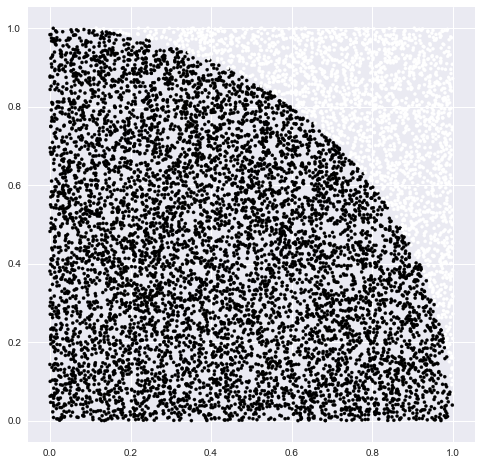

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(style="darkgrid", palette="muted", color_codes=True)
# 描画する
res = calc_pi(X2)
n_plot = 10**4  # 描画する点の数
plt.figure(figsize=(8,8))
plt.scatter(X2[:n_plot,0], X2[:n_plot,1], c=res[:n_plot], s=10)